# Independent Component Analysis (ICA)
python

data: file audio musik (wav)

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def g(x):
    return np.tanh(x)

def g_der(x):
    return 1 - g(x) * g(x)

def center(x):
    x = np.array(x)
    
    mean = x.mean(axis=1, keepdims=True)
    
    return x - mean

def whitening(x):
    cov = np.cov(x)

    d, E = np.linalg.eigh(cov)

    D = np.diag(d)

    D_inv = np.sqrt(np.linalg.inv(D))

    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))

    return x_whiten

def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w

    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

def showProgress(n, cond=False, showTime=False):
    if cond:
        pad = "="*8
        st = ""
        if showTime:
            st = time.time()
        print(pad + f"iter {n} {st}" + pad)
    return

def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    X = whitening(X)
    
    print(X.shape)
    
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range(components_nr):
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            
            showProgress(j, j%10 == 0)
            
            if distance < tolerance:
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S

In [3]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [35]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

def addNoise(data, factor=0.00001):
#     return data+0.00001*np.random.rand(data.shape[1], data.shape[0])
    return data + factor * np.random.normal(1,100,data.shape[0])

# addNoise(np.array([1,2,3]))

In [43]:
def readWav(fname, all=False, flatten=False):
    sampling_rate, digit = wavfile.read(fname)
    
    if flatten:
        digit = digit.flatten
    
    if all:
        return sampling_rate, digit
    else:
        return digit

def mixAndTrain():
    pass

In [44]:
fnames = [
    "audios/gdmh-ar8.wav",
    "audios/gdmh-ar8-32kb-10s.wav",
    "audios/gdmh-ar8-32kb-10s.wav",
#     "mix1.wav",
#     "mix2.wav",
    "audios/gdmh-ar8-32kb.wav",
    "audios/dejavu.wav",
    "audios/hymne.wav",
]
sampling_rate, mix1 = wavfile.read(fnames[1])
mix1 = mix1.flatten()
print(sampling_rate, mix1)
sampling_rate, mix2 = wavfile.read(fnames[2])
mix2 = addNoise(mix2.flatten(), 10)
print(sampling_rate, mix2)

# sampling_rate, source1 = wavfile.read('source1.wav')
# sampling_rate, source2 = wavfile.read('source2.wav')

# actual = mix_sources([source1, source2], False)
X = mix_sources([mix1, mix2])
print(X.shape)
S = ica(X, iterations=100)

wavfile.write('audios/out1.wav', sampling_rate, S[0])
wavfile.write('audios/out2.wav', sampling_rate, S[1])

8000 [ 67  80 104 ... 130 140  86]
8000 [ -461.61942923  -280.96282641  2059.34215146 ...   524.00747135
  1927.99594281 -1346.871252  ]
(2, 50000)
(2, 50000)
========iter 0 ========
========iter 0 ========
========iter 10 ========
========iter 20 ========
========iter 30 ========
========iter 40 ========
========iter 50 ========
========iter 60 ========
========iter 70 ========
========iter 80 ========
========iter 90 ========


In [37]:
X

array([[-0.13004895, -0.57278144,  0.02760162, ..., -0.58801873,
        -0.49072143, -0.50204299],
       [-0.07351452, -0.33632667, -0.18099279, ..., -0.59447155,
        -0.48937672, -0.56497566]])

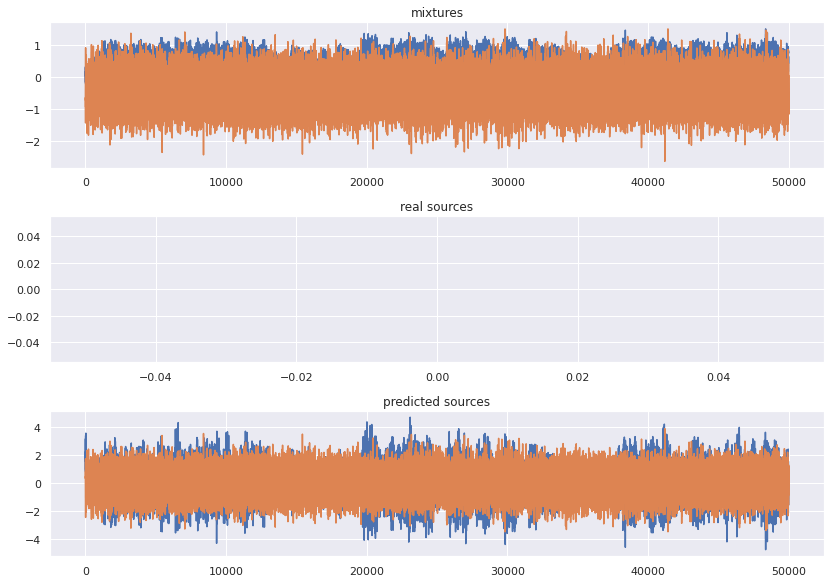

In [45]:
plot_mixture_sources_predictions(X, [0, 0], S)

In [13]:
pd.DataFrame([S[0],S[1]]).describe()

,0,1,2,3,4,5,6,7,8,9,...,159734,159735,159736,159737,159738,159739,159740,159741,159742,159743
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,-0.033257,0.849957,0.925484,0.403379,1.120386,0.548898,1.262748,0.521662,1.041423,0.780758,...,0.782638,0.223945,-0.789103,-0.046135,-0.171192,0.517965,-0.051069,-1.033218,0.674003,-0.134294
std,1.587243,1.526803,0.864153,0.233216,1.763542,0.247083,2.451812,0.823194,2.572499,0.603862,...,1.416830,0.491768,0.614959,0.254504,0.194359,1.196207,0.234646,1.119299,0.931990,0.183864
min,-1.155608,-0.229655,0.314435,0.238470,-0.126627,0.374184,-0.470945,-0.060424,-0.777609,0.353763,...,-0.219212,-0.123787,-1.223945,-0.226096,-0.308625,-0.327880,-0.216989,-1.824682,0.014986,-0.264305
25%,-0.594433,0.310151,0.619960,0.320924,0.496880,0.461541,0.395901,0.230619,0.131907,0.567260,...,0.281713,0.050079,-1.006524,-0.136116,-0.239908,0.095042,-0.134029,-1.428950,0.344495,-0.199300
50%,-0.033257,0.849957,0.925484,0.403379,1.120386,0.548898,1.262748,0.521662,1.041423,0.780758,...,0.782638,0.223945,-0.789103,-0.046135,-0.171192,0.517965,-0.051069,-1.033218,0.674003,-0.134294
75%,0.527918,1.389764,1.231008,0.485833,1.743892,0.636255,2.129594,0.812706,1.950938,0.994255,...,1.283563,0.397811,-0.571682,0.043846,-0.102476,0.940888,0.031890,-0.637486,1.003512,-0.069289
max,1.089093,1.929570,1.536532,0.568287,2.367398,0.723612,2.996440,1.103749,2.860454,1.207753,...,1.784488,0.571677,-0.354261,0.133826,-0.033759,1.363811,0.114850,-0.241755,1.333020,-0.004283
